<div style="text-align: center;">

# **Algoritmia Cuantica** 
# Sumador Cuantico  utilizando QFT
  
<font size="2">

##### Daniel Amauri Vázquez Gutiérrez
</font>


**Realiza un circuito cuántico sumador usando la QFT.**

Como sabemos desde la practica pasada, la transformada cuantica de fourier  cambia nuestros qbits de un codigo binario a un codigo encriptado en las fases del qbit, esto nos facilitara el hacer nuestra fuma mediante  rotaciones. 

Primero ,inicializamos nuestro programa y añadimos `from qiskit.circuit import Gate`, lo cual nos permitira definir una nueva compuerta cuantica que no esta incluida en las compuertas estandar. 



In [92]:
#Bloque de importacion
import numpy as np 
import math
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer #Aer es un modulo de Qiskit que proporciona simuladores cuanticos para ejecutarlos de manera local.  
from qiskit.quantum_info import Statevector,DensityMatrix
from qiskit.visualization import plot_histogram,plot_bloch_multivector
from qiskit.circuit import Gate

import qiskit 
print(qiskit.version.get_version_info()) 

1.2.0


Primero definimos una Compuerta que nos encripte   apartir de cierto numero de Qbits  y algun numero que queramos $n$ bajo codigo binario , el circuito. 

In [104]:
# Definir la compuerta personalizada que realiza la encriptacion de los numeros en binario en los Qbits
class Encript0(Gate):
    def __init__(self, n, s): 

         #Aqui _init_  es el constructor de la clase 
         
        # n es el número que será representado en binario, s es el número de qubits

        super().__init__('ENKPT', s, [n])  # La etiqueta de la compuerta y el número de qubits 

        #Se utiliza para inicializar la parte de la instancia que proviene de la clase base,
        # asegurando que toda la funcionalidad heredada esté configurada correctamente. recordando que estamos heredando  funcionalidades de la 
        #clase Gate 

        self.s=s
        self.n=n
        

    def _define(self):
        qc = QuantumCircuit(self.s)

        # Inicializar los qubits según el valor de n
        t = self.n
        for i in range(self.s):
            if t % 2 == 1:
                qc.x(i)  # Aplicar X a los qubits correspondientes
            t = t // 2

        

        self.definition = qc  # Definir el circuito como la implementación de la compuerta




Para la posterior verificacion de los resultados , hacemos una pequeña funcion que codifique nuestros numeros de decimal a binario en un arreglo

In [117]:
def BIN(n,s,r):
    #Apartir de nuestro numero , inicializamos nustros qbits con !
    t=n
    for i in range(s):    #por nomenglatura de Qskit , entramos el valor de nuestro numero binario alreves, comenzando vel valor mas pequeño . 
        if(t%2==1):  
            r[s-(i+1)]=1  #Usamos un arreglo que codifica nuestro numero en binario // Util despues 
        t=t//2 

Apartir de nuestro practica anterior , definimos nuestra Quantum Fourier Transform $QFT$

In [94]:
# Definir la compuerta personalizada que realiza la Transformada Cuantica 
class QFT(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('QFT_CUSTOM', s,[])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        
       

    def _define(self):
        qc = QuantumCircuit(self.s)

        # Aplicar la Transformada Cuantica de Fourier 
        for j in range(self.s):
            qc.h(self.s - (j + 1))
            if self.s - (j + 1) > 0:
                for k in range(self.s - (j + 1)):
                    l = self.s - (j + 1) - 1 - k
                    qc.cp(2 * np.pi / (2 ** (self.s - j - l)), l, self.s - (j + 1))

        # Aplicar los swaps necesarios
        if self.s % 2 == 1:
            for l in range((self.s - 1) // 2):
                qc.swap(l, self.s - 1 - l)
        else:
            for l in range(self.s // 2):
                qc.swap(l, self.s - 1 - l)

        self.definition = qc  




Asi como tambien definimos la Transformada cuantica de fourier Inversa $IQFT$ 

In [95]:
#Transformada Cuantica de Fourier Inversa  

class IQFT(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('IQFT_CUSTOM', s, [])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        

    def _define(self):
         qc = QuantumCircuit(self.s)
 
         #Primero volvemos a Switchear 
         if self.s % 2 == 1:
               for l in range((self.s - 1) // 2):
                  qc.swap(l, self.s - 1 - l)
         else:
               for l in range(self.s // 2):
                  qc.swap(l, self.s - 1 - l)


            #Volvemos a añadir las compuertas pero ahora en un sentido invertido 

         for j in range(self.s):  
               qc.h(j)

               if j<(self.s-1):
                  for k in range(j+1):
                     qc.cp(2*np.pi/(-2**(k+2)),j+1,j-k)   

         
            #Agragamos este SWAP que no deberia ser nesesario , sin embargo , lo ponemos dado que esto nos permite ver los estados de los Qbits en un orden
            #usal en el que vemos los numeros binarios y asi poderlo comparar con el arreglo original que producimos al inicializar el circuito. 

         
         self.definition = qc  

*Añado que para que funcionaran correctamente las formas de visualizacion , tanto usando Statevector como  Histogram, fue nesesario cambiar las etiquetas que estaba epleando al definir las clases , ya que aparentemente $qft$ ya estaba siendo utilizada para  la compuerta preprogramada en Qskit de  Quantum Fourier Transform*

In [96]:
# SWAP  cumtomizado  
class SWAP(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('SWAP_CUSTOM', s, [])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        

    def _define(self):
         qc = QuantumCircuit(self.s)
 
         #Primero volvemos a Switchear 
         if self.s % 2 == 1:
               for l in range((self.s - 1) // 2):
                  qc.swap(l, self.s - 1 - l)
         else:
               for l in range(self.s // 2):
                  qc.swap(l, self.s - 1 - l)


         
         self.definition = qc  

        

Pedimos el numero de de Qbits que se quieran utilizar   y posteriormente  pedimos un numero que sea capaz de ser representado   con ese numero de Qbits 

In [130]:
s=int(input("Ingresa un numero natural de qbits a utilizar para ambos numeros  que se sumaran : "))  

Ahora pedimos los dos numeros a ser sumados 

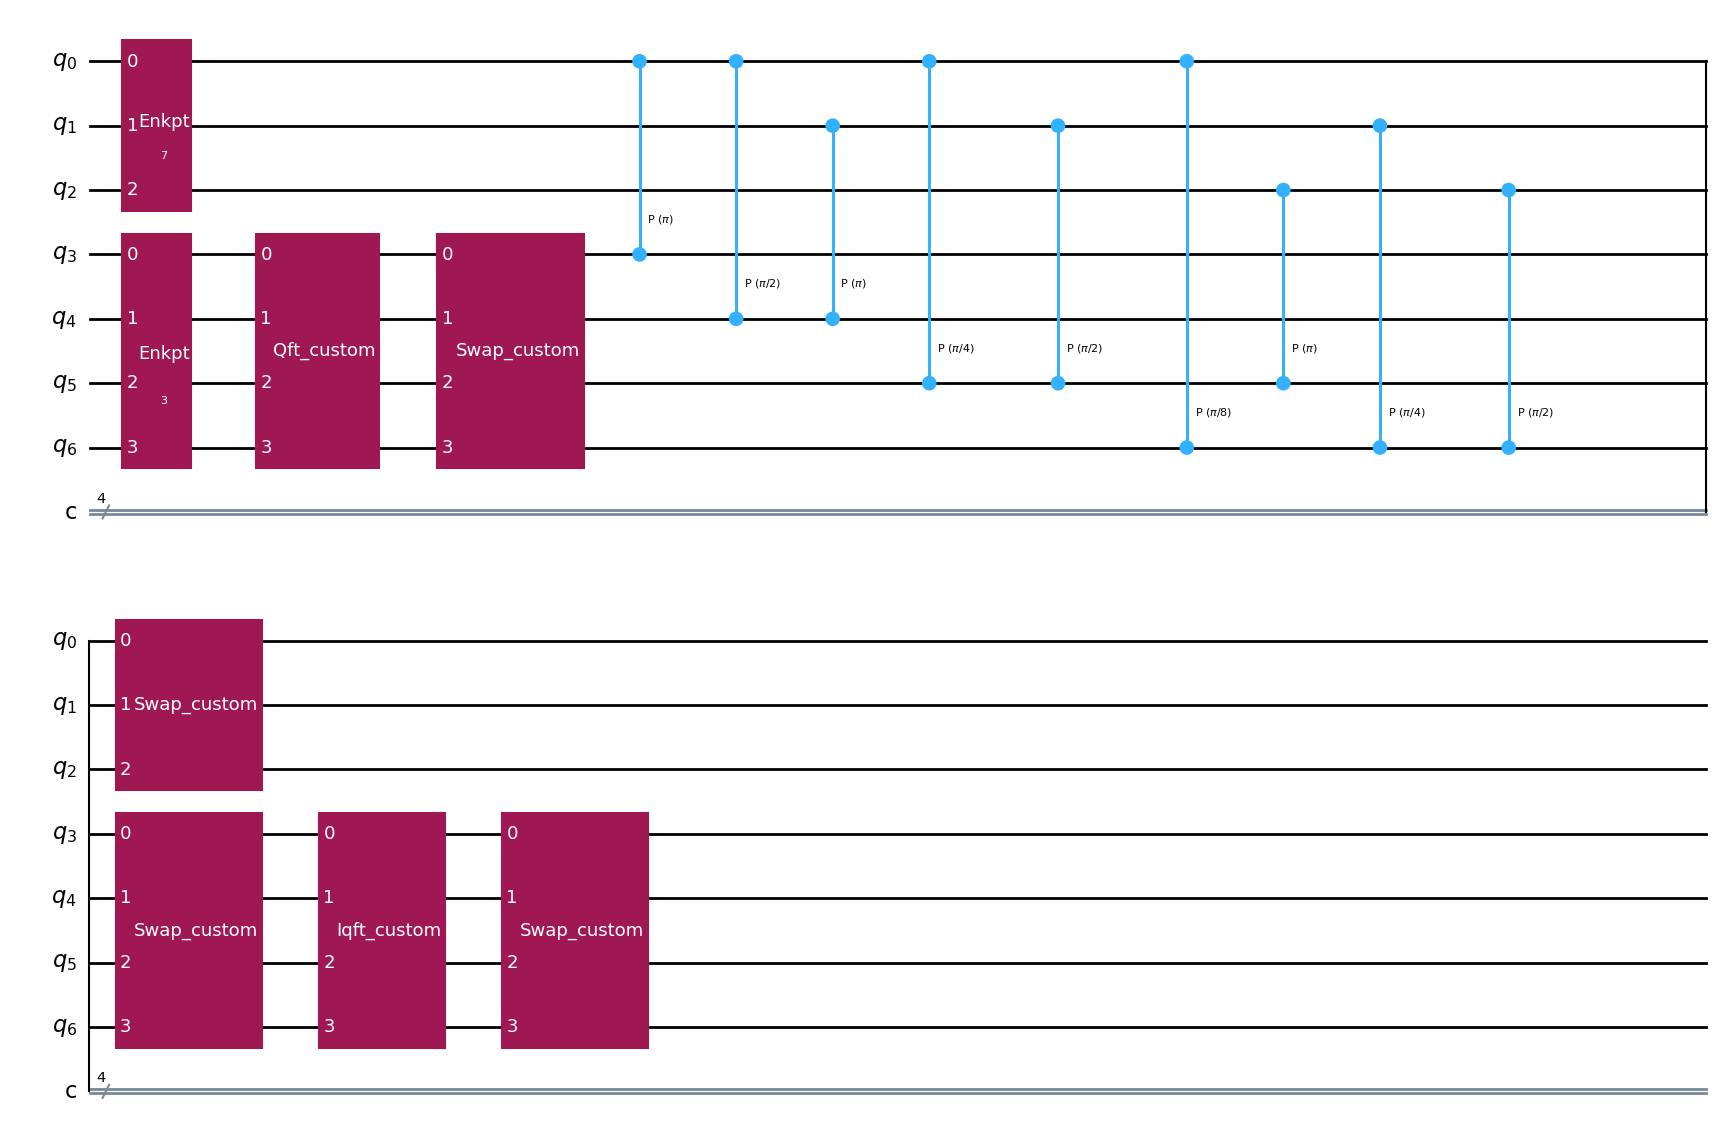

In [131]:
r=int(input(f"Ingresa el primer numero natural a ser sumado  menor a {2**s}: "))
n=int(input(f"Ingresa el segundo numero natural a ser sumado  menor a {2**s}: "))

qc = QuantumCircuit(2*s+1,s+1) # El mas uno lo usaremos como acarreo 

#Indicamos grupos de Qbits 
numero_1 = list(range(s, 2*s+1))  #Primer numero y el que sera transformado 
numero_2 = list(range(0, s))   #segundo numero 

#Aqui se crean atajos para facilitar  la aplicacion de compuertas. 

inicial_1= Encript0(r, s+1)
inicial_2= Encript0(n, s)    

qft_1=QFT(s+1)
iqft_1=IQFT(s+1) 


# Aplicar la compuerta personalizada solo a los a  algunos qbits 

qc.append(inicial_1, numero_1)  # los grupos indican a quien se esta aplicando cada compuerta 
qc.append(inicial_2, numero_2) 
qc.append(qft_1, numero_1)   
qc.append(SWAP(s+1),numero_1) #Nesesario por el como se  aplicaran las compuertas de rotacion posteriormente. 
#Podriamos evitar este ultimo paso , sin embargo , tendria que modificar mi compuerta QFT original , y la idea  es que esta se mantenga intacta . 

#Aplicamos las rotaciones  nesesarias  en funcion de si esta o no activos los primeros qbits

for i in range(s): #Manejamos todos menos el ultimo termino  para manejarlo aparte para el acarreo 
    for j in range(i + 1):
        # La rotación de fase controlada CROT( fase, control, objetivo )
        qc.cp(2 * np.pi / (2 ** (i - j + 1)), numero_2[j], numero_1[i])

for j in range(s):
        qc.cp(2 * np.pi / (2 ** (s - j +1)), numero_2[j], numero_1[s])   #Esta seccion es unicamente echa para añadir  modificar especificamente el qbit de acarreo. 



qc.append(SWAP(s+1),numero_1) 
qc.append(iqft_1, numero_1) #aplicamos la transformada de fourier inversa  

#Estas ultimas compuertas SWAP las aplico solo para que  el como obtenemos los qbits concuerde con la convencion de orden en el codigo binario del que estamos acostumbrado. 
qc.append(SWAP(s+1),numero_1)
qc.append(SWAP(s),numero_2) 


qc.draw('mpl')


A continuacion , empleando `plot_bloch_multivector` , plasmamos nuestros resultados. Si elegimos un numero S de Qbits para cada numero  a sumar, los primeros S Qbits mostrados respresentan el segundo numero  ingresado, mientras que los ultimos S+1 Qbits, representan la suma de los dos numeros ingresados. 


*no se encontro la forma adecuada para que unicamente me representaran los ultimos S+1 qbits, si existe una forma , pido porfavor que se comente el como se logra esto*

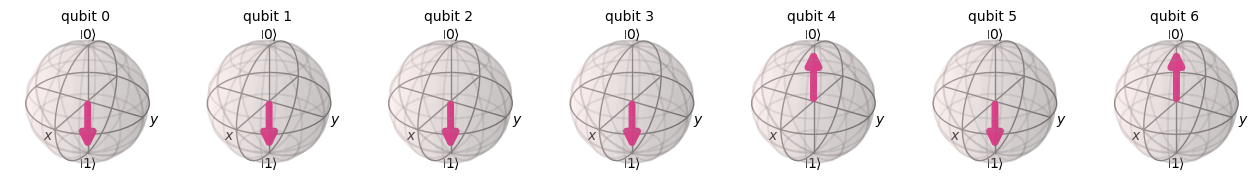

In [132]:
state=Statevector(qc)
plot_bloch_multivector(state)

Ahora comparamos esto con la combinacion binaria que corresponde a estos numeros : 

In [136]:
#--------Hacemos la suma binaria del los arreglos de forma clasica--------
#Transformaremos 
CLASIC_numero_1=np.zeros(s+1)
CLASIC_numero_2=np.zeros(s) 

BIN(r,s+1,CLASIC_numero_1)
BIN(n,s,CLASIC_numero_2)

Sum_Clasic_num=np.zeros(s+1)
BIN(r+n,s+1,Sum_Clasic_num)

print(f"Primeros  {s} Qbits:") 

print(CLASIC_numero_2) 

print(f"Ultimos   {s+1} Qbits:")
print(Sum_Clasic_num)

Primeros  3 Qbits:
[1. 1. 1.]
Ultimos   4 Qbits:
[1. 0. 1. 0.]
